In [1]:
# %matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks', {"axes.linewidth": "1",'axes.yaxis.grid':False})

In [2]:
# from phys.plot_scripts.decoding_summary import PlotHelper
from utils.decoding_summary import PlotHelper

/Users/hansem/Dropbox (MIT)/MPong/phys/results/old_from_rishi_om/decode_results_old//decode_all_hand_dmfc_occ_start_end_pad0_50ms_0.50_neural_responses_reliable_FactorAnalysis_50.pkl
[0.8967107701839062, 0.90894310929273]
[0.014652169418241448, 0.021344804581297255]
[0.8032656203704934, 0.8491232757763335]
[0.034278436278089054, 0.036026340790098914]
[0.845876695107022, 0.5415986171083789]
[0.07052734110468871, 0.0665224635936488]
[2.367865745528589, 2.1648622211513846]
[0.23610011750284443, 0.2464316534223179]
[nan, nan]
[nan, nan]
[nan, nan]
[nan, nan]


/opt/anaconda3/envs/mworks/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/hansem/Dropbox (MIT)/MPong/phys/plot_scripts/decoding_summary.py:148: RuntimeWarning: Mean of empty slice
  mae_t = np.nanmean(np.abs(x_cxt - y_cxt), axis=0)
/Users/hansem/Dropbox (MIT)/MPong/phys/plot_scripts/decoding_summary.py:149: RuntimeWarning: Mean of empty slice
  mse_t = np.nanmean((x_cxt - y_cxt) ** 2, axis=0)
/opt/anaconda3/envs/mworks/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/hansem/Dropbox (MIT)/MPong/phys/plot_scripts/decoding_summary.py:601: RuntimeWarning: Mean of empty slice
  mu.append(np.nanmean(x, axis=0))
/opt/anaconda3/envs/mwo

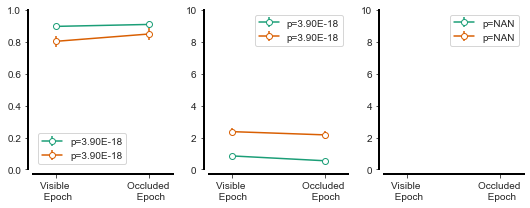

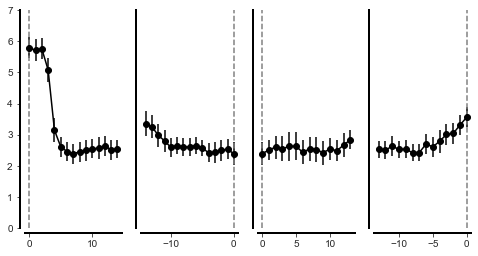

In [3]:
ph = PlotHelper(timebinsize=50,
                subject_id='all_hand_dmfc',
                masks_to_test_suffix='start_end_pad0',
                condition='occ',
                neural_data_to_use='neural_responses_reliable_FactorAnalysis_50',
                ncomp=50)

ph.load_data()
ph.load_ground_truth_data()
ph.get_colormap_for_decoded_variables()

self = ph

self.plot_decode_performance_unrolled_over_time(compute_egocentric=False)